In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/Users/willwolf/Documents/willwolf/dotify


In [3]:
# delete this eventually

import os

os.environ['SQLALCHEMY_DATABASE_URI'] = os.environ['DIGITAL_OCEAN_SQLALCHEMY_DATABASE_URI']

In [4]:
from copy import deepcopy
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine

from dotify.config import DevelopmentConfig as Config
from dotify.recommendation.implicit_mf.ratings_matrix import RatingsMatrix
from dotify.recommendation.implicit_mf.implicit_mf import ImplicitMF

ENGINE = create_engine(Config.SQLALCHEMY_DATABASE_URI)

%matplotlib inline

In [89]:
ratings_matrix = RatingsMatrix(n_top_songs=10000, eps=1e3)

In [90]:
# split into train, test sets

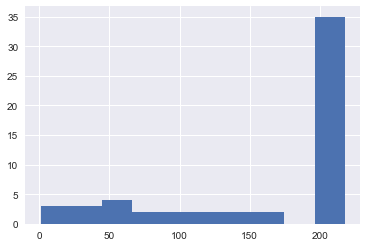

In [91]:
(ratings_matrix.R_ui > 0).sum(axis=1).hist()

In [92]:
np.percentile((ratings_matrix.R_ui > 0).sum(axis=1), 25)

111.5

In [93]:
more_than_50_ratings_mask = (ratings_matrix.R_ui > 0).sum(axis=1) > 50

In [94]:
FRACTION_TO_DROP = .2
TRAINING_MATRIX = ratings_matrix
VALIDATION_MATRIX = deepcopy(TRAINING_MATRIX)
VALIDATION_MATRIX.R_ui = pd.DataFrame(0., index=TRAINING_MATRIX.R_ui.index, columns=TRAINING_MATRIX.R_ui.columns)

for country_id, ratings in TRAINING_MATRIX.R_ui[more_than_50_ratings_mask].iterrows():
    rated_songs_mask = TRAINING_MATRIX.R_ui.ix[country_id] > 0
    rated_songs = TRAINING_MATRIX.R_ui.ix[country_id][rated_songs_mask].index.tolist()
    nb_songs_to_drop = int( len(rated_songs)*FRACTION_TO_DROP )
    songs_to_drop = set( random.sample(rated_songs, nb_songs_to_drop) )
    
    VALIDATION_MATRIX.R_ui.ix[country_id][songs_to_drop] = TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop]
    TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop] = 0.

In [95]:
F = 30
ALPHA = 1
LAMBDA = 25

In [96]:
implicit_mf = ImplicitMF(ratings_matrix=TRAINING_MATRIX, f=F, alpha=ALPHA, lmbda=LAMBDA)

In [97]:
print(implicit_mf.country_vectors.vectors.shape)
print(implicit_mf.song_vectors.vectors.shape)

(55, 30)
(2130, 30)


In [98]:
implicit_mf.run()

0
1
2
3
4
5
6
7
8
9


In [99]:
implicit_mf.country_vectors.vectors.to_csv('data/country_vectors.csv')
implicit_mf.song_vectors.vectors.to_csv('data/song_vectors.csv')
# implicit_mf.country_vectors.vectors = pd.read_csv('data/country_vectors.csv', index_col=['country_id'])
# implicit_mf.song_vectors.vectors = pd.read_csv('data/song_vectors.csv', index_col=['song_id'])

In [100]:
# make the names shorter

In [101]:
country_vectors_df = implicit_mf.country_vectors.vectors
song_vectors_df = implicit_mf.song_vectors.vectors

# Evaluate

In [102]:
predicted_preferences = country_vectors_df.dot(song_vectors_df.T)

In [103]:
class ExpectedPercentileRankingsEvaluator:
    
    def __init__(self, training_matrix, validation_matrix, predicted_preferences):
        self.training_matrix = training_matrix
        self.validation_matrix = validation_matrix
        self.predicted_preferences = predicted_preferences
        self.expected_percentile_rankings_train = []
        self.expected_percentile_rankings_validation = []
        
    def run(self):
        self._evaluate_train()
        self._evaluate_validation()

    def _evaluate_train(self):
        self.expected_percentile_rankings_train = self._evaluate(matrix=self.training_matrix)
        
    def _evaluate_validation(self):
        self.expected_percentile_rankings_validation = self._evaluate(matrix=self.validation_matrix)
        
    def _evaluate(self, matrix):
        expected_percentile_rankings = []
        for country_id, preferences in predicted_preferences[more_than_50_ratings_mask].iterrows():
            predictions = pd.DataFrame({
                'predicted_preference': preferences.sort_values(ascending=False),
                'rank': np.arange( len(preferences) ),
                'percentile_rank': np.arange( len(preferences) ) / len(preferences)
            })
            ground_truth = matrix.R_ui.ix[country_id][ matrix.R_ui.ix[country_id] > 0 ]
            numerator = (ground_truth * predictions['percentile_rank'][ground_truth.index]).sum()
            denominator = ground_truth.sum()
            expected_percentile_rankings.append( numerator / denominator )

        return expected_percentile_rankings

In [104]:
evaluator = ExpectedPercentileRankingsEvaluator(
    training_matrix=TRAINING_MATRIX,
    validation_matrix=VALIDATION_MATRIX,
    predicted_preferences=predicted_preferences
)
evaluator.run()

In [106]:
np.mean(evaluator.expected_percentile_rankings_train)

0.055394709558441967

In [ ]:
# with a list of expected ranking values, we could compute the entropy in this distribution

## Visualize

In [ ]:
# change countries index form id to name

In [ ]:
sns.set(style="white")

In [ ]:
from dotify.resources.countries import countries as countries_lookup


country_id_to_name = {countries_lookup[name]['id']: name for name in countries_lookup}


def replace_country_id_index_with_country_names(df):
    country_ids = df.index
    df.index = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
    return df


country_ids = country_vectors_df.index
country_names = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
country_vectors_df.index = country_names

In [ ]:
def plot_cosine_similarities(country_vectors_df):

    # compute the cosine similarity matrix
    similarities_df = pd.DataFrame(
        data=cosine_similarity(country_vectors_df),
        index=country_vectors_df.index,
        columns=country_vectors_df.index
    )
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(similarities_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(21, 21))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(similarities_df, mask=mask, cmap=cmap, vmax=.5,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=1, cbar_kws={"shrink": .5}, ax=ax)

In [ ]:
plot_cosine_similarities(country_vectors_df)

# tsne

In [ ]:
from matplotlib import pylab
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [ ]:
country_embeddings = pd.DataFrame(
    data=tsne.fit_transform(country_vectors_df),
    index=country_vectors_df.index,
    columns=['dim_1', 'dim_2']
)

In [ ]:
def plot_tsne_embeddings(country_embeddings):

    pylab.figure(figsize=(15,15))

    for country_name, country_embedding in country_embeddings.iterrows():
        dim_1, dim_2 = country_embedding
        pylab.scatter(dim_1, dim_2)
        pylab.annotate(country_name, xy=(dim_1, dim_2), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

In [ ]:
plot_tsne_embeddings(country_embeddings)

## Inspect arithmetic combinations

In [ ]:
SONG_VECTORS_QUERY = """
    SELECT 
        songs.title as song_title, 
        songs.artist as song_artist,
        song_vectors.* 
    FROM song_vectors 
    JOIN songs ON songs.id = song_vectors.song_id
"""

song_vectors_df = pd.read_sql(SONG_VECTORS_QUERY, ENGINE, index_col=['song_title', 'song_artist'])
song_vectors_df.drop('song_id', axis=1, inplace=True)

In [ ]:
country_vec = country_vectors_df.ix['United States']

In [ ]:
song_vectors_df.apply(lambda vec: np.dot(vec, country_vec), axis=1).sort_values(ascending=False).head(10)

In [ ]:
country_vec = country_vectors_df.ix['Colombia']

In [ ]:
song_vectors_df.apply(lambda vec: np.dot(vec, country_vec), axis=1).sort_values(ascending=False).head(10)

In [ ]:
country_vec = country_vectors_df.ix['France']

In [ ]:
song_vectors_df.apply(lambda vec: np.dot(vec, country_vec), axis=1).sort_values(ascending=False).head(10)